# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 167580478.55it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41371480.13it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 108776347.48it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 6026741.15it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


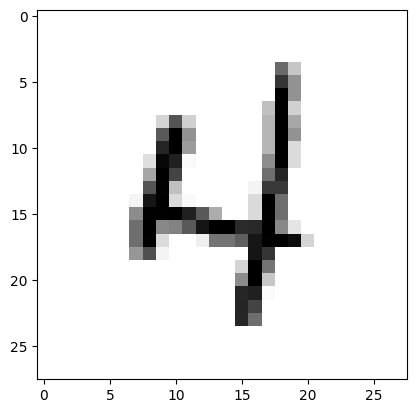

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

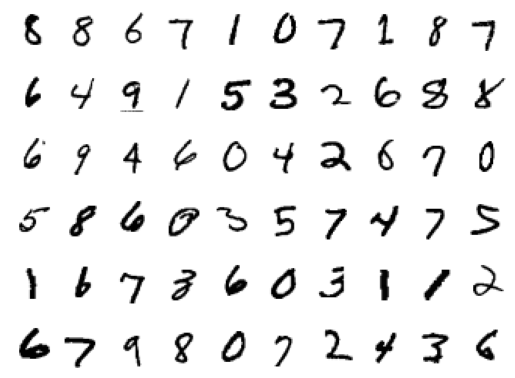

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Model


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26 RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24 RF = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 22 RF = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11 RF = 8
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 11 RF = 8

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 9 RF = 12
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7 RF = 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 7 RF = 16
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1 RF = 28

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 20, 24, 24]           1,800
              ReLU-4           [-1, 20, 24, 24]               0
            Conv2d-5           [-1, 30, 22, 22]           5,400
              ReLU-6           [-1, 30, 22, 22]               0
         MaxPool2d-7           [-1, 30, 11, 11]               0
            Conv2d-8           [-1, 10, 11, 11]             300
              ReLU-9           [-1, 10, 11, 11]               0
           Conv2d-10             [-1, 20, 9, 9]           1,800
             ReLU-11             [-1, 20, 9, 9]               0
           Conv2d-12             [-1, 30, 7, 7]           5,400

# Training and Testing


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.3011021614074707 Batch_id=468 Accuracy=24.07: 100%|██████████| 469/469 [00:20<00:00, 22.34it/s]



Test set: Average loss: 2.3012, Accuracy: 3712/10000 (37.12%)

EPOCH: 1


Loss=0.19162379205226898 Batch_id=468 Accuracy=72.92: 100%|██████████| 469/469 [00:22<00:00, 21.23it/s]



Test set: Average loss: 0.2028, Accuracy: 9346/10000 (93.46%)

EPOCH: 2


Loss=0.0728888139128685 Batch_id=468 Accuracy=95.22: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]



Test set: Average loss: 0.1043, Accuracy: 9671/10000 (96.71%)

EPOCH: 3


Loss=0.0380023829638958 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]



Test set: Average loss: 0.0863, Accuracy: 9738/10000 (97.38%)

EPOCH: 4


Loss=0.038225527852773666 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:20<00:00, 22.49it/s]



Test set: Average loss: 0.0730, Accuracy: 9772/10000 (97.72%)

EPOCH: 5


Loss=0.09478428959846497 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:17<00:00, 26.50it/s]



Test set: Average loss: 0.0611, Accuracy: 9810/10000 (98.10%)

EPOCH: 6


Loss=0.09502879530191422 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:17<00:00, 26.54it/s]



Test set: Average loss: 0.0530, Accuracy: 9831/10000 (98.31%)

EPOCH: 7


Loss=0.02925773523747921 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0445, Accuracy: 9868/10000 (98.68%)

EPOCH: 8


Loss=0.03608355671167374 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]



Test set: Average loss: 0.0394, Accuracy: 9878/10000 (98.78%)

EPOCH: 9


Loss=0.015980174764990807 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:18<00:00, 25.77it/s]



Test set: Average loss: 0.0514, Accuracy: 9841/10000 (98.41%)

EPOCH: 10


Loss=0.026958391070365906 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]



Test set: Average loss: 0.0363, Accuracy: 9880/10000 (98.80%)

EPOCH: 11


Loss=0.0077623301185667515 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:17<00:00, 26.91it/s]



Test set: Average loss: 0.0379, Accuracy: 9867/10000 (98.67%)

EPOCH: 12


Loss=0.06335514038801193 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:20<00:00, 23.34it/s]



Test set: Average loss: 0.0373, Accuracy: 9875/10000 (98.75%)

EPOCH: 13


Loss=0.07492776960134506 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]



Test set: Average loss: 0.0345, Accuracy: 9881/10000 (98.81%)

EPOCH: 14


Loss=0.018378879874944687 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:18<00:00, 25.38it/s]



Test set: Average loss: 0.0406, Accuracy: 9875/10000 (98.75%)

EPOCH: 15


Loss=0.014331487007439137 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:17<00:00, 26.85it/s]



Test set: Average loss: 0.0371, Accuracy: 9875/10000 (98.75%)

EPOCH: 16


Loss=0.05267461761832237 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:18<00:00, 24.91it/s]



Test set: Average loss: 0.0379, Accuracy: 9885/10000 (98.85%)

EPOCH: 17


Loss=0.03030727058649063 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]



Test set: Average loss: 0.0375, Accuracy: 9871/10000 (98.71%)

EPOCH: 18


Loss=0.008892293088138103 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]



Test set: Average loss: 0.0346, Accuracy: 9891/10000 (98.91%)

EPOCH: 19


Loss=0.018775179982185364 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]



Test set: Average loss: 0.0370, Accuracy: 9882/10000 (98.82%)



Text(0.5, 1.0, 'Test Accuracy')

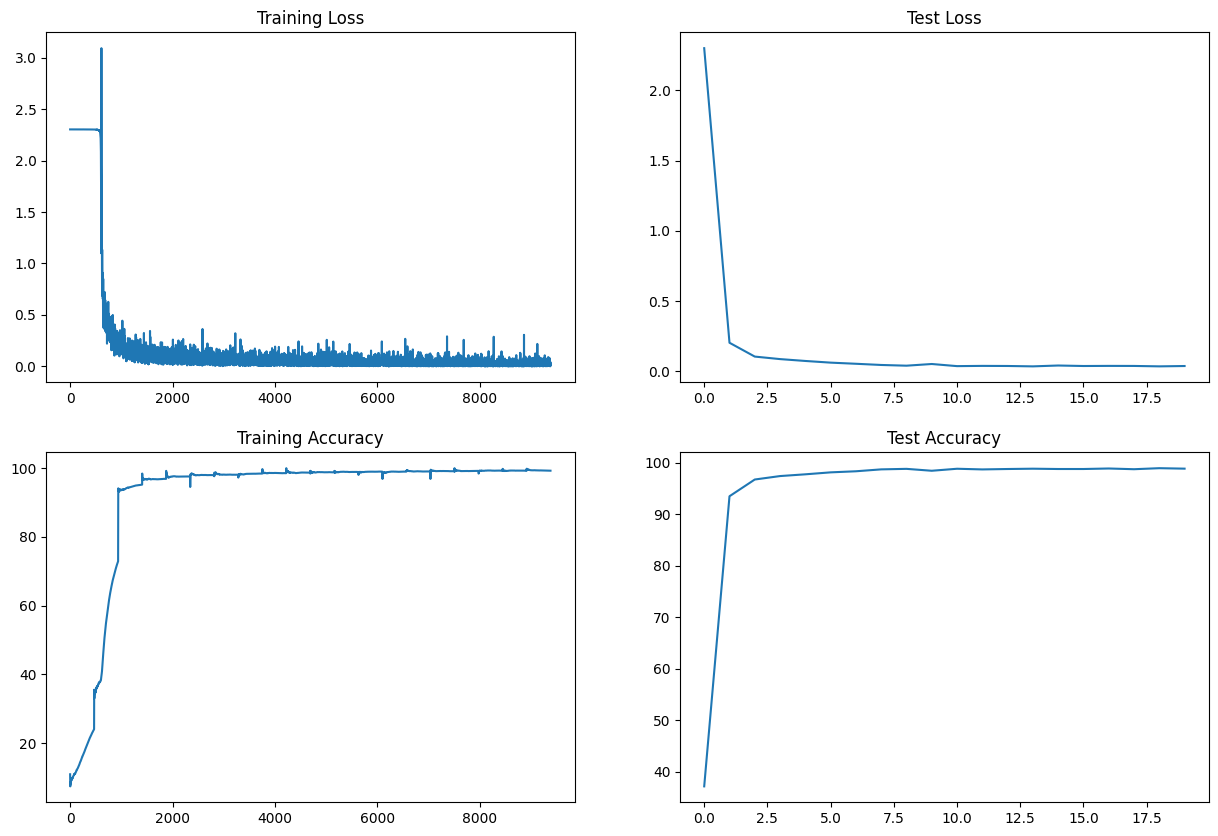

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target
First lets look at a basic skeleton that can provide us a foundation to work with. Here we will not be sticking to any of the constraints stated above. We will just be looking at the accuracy of the model and understand whether the model is overfitting or whether it can be used further for our model development. We shall define the dataloader, a working code, a skeleton for our neural network, training and testing less with optimizer for the training part and displaying the basic data that we are working with. 

## Results        
- Total parameters - 19,990
- Best Training Accuracy - 99.27%
- Best Testing Accuracy - 98.91% 

## Analysis
The model is light since it only has 20k parameters. The model is also performing overall pretty well since the overfitting it very minimal. We shall work on reducing the number of parameters and the epochs in the next model.